In [ ]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import resample
import wfdb
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Load a single record (e.g., record 100)
record = wfdb.rdrecord('/content/drive/MyDrive/DL-Project/Data/mit-bih-arrhythmia-database-1.0.0/100')
annotation = wfdb.rdann('/content/drive/MyDrive/DL-Project/Data/mit-bih-arrhythmia-database-1.0.0/100', 'atr')

# Extract signals and annotations
signals = record.p_signal  # ECG signals (2 channels)
fs = record.fs  # Sampling frequency
annotations = annotation.sample  # Annotation positions in samples
labels = annotation.symbol  # Annotation symbols

In [ ]:
from scipy.signal import butter, filtfilt

def highpass_filter(signal, cutoff=0.5, fs=360, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

filtered_signal = highpass_filter(signals[:, 0])  # Apply to channel 1


In [ ]:
filtered_signal

array([0.05799047, 0.0583831 , 0.0587769 , ..., 2.33529059, 2.27831408,
       1.79654571])

In [ ]:
normalized_signal = (filtered_signal - np.mean(filtered_signal)) / np.std(filtered_signal)


In [ ]:
normalized_signal

array([ 0.31038525,  0.31248637,  0.31459374, ..., 12.4970077 ,
       12.19210667,  9.6139971 ])

In [ ]:
normalized_signal.shape

(650000,)

In [ ]:
def extract_segments(signals, annotations, labels, fs, segment_duration=2):
    segments = []
    segment_labels = []
    segment_length = segment_duration * fs // 2

    for i, idx in enumerate(annotations):
        start = max(0, idx - segment_length)
        end = min(len(signals), idx + segment_length)
        segment = signals[start:end]

        # Pad if the segment is shorter than desired length
        if len(segment) < 2 * segment_length:
            segment = np.pad(segment, (0, 2 * segment_length - len(segment)), 'constant')

        segments.append(segment)
        segment_labels.append(labels[i])

    return np.array(segments), np.array(segment_labels)

segments, segment_labels = extract_segments(normalized_signal, annotations, labels, fs)


In [ ]:
segments.shape

(2274, 720)

In [ ]:
segment_labels

array(['+', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels as integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(segment_labels)

# Check label mapping
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


{'+': 0, 'A': 1, 'N': 2, 'V': 3}


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)


{0: 568.5, 1: 17.227272727272727, 2: 0.2539079946404645, 3: 568.5}


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(segments, encoded_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
X_train.shape

(1591, 720)

In [ ]:
import numpy as np
from tensorflow.keras import models, layers
from sklearn.metrics import classification_report, f1_score


In [ ]:
import numpy as np
from tensorflow.keras import models, layers
from sklearn.metrics import classification_report, f1_score

def build_rnn_model(input_shape, num_classes):
    model = models.Sequential()

    # Add an LSTM layer
    model.add(layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(layers.LSTM(64))

    # Add fully connected layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularization
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the model
# Reshape X_train to have 3 dimensions (samples, timesteps, features)
# Assuming each timestep has 1 feature
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(np.unique(y_train))
model = build_rnn_model(input_shape, num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 720, 64)             │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,340 (212.27 KB)

 Trainable params: 54,340 (212.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.8195 - loss: 0.8504 - val_accuracy: 0.9795 - val_loss: 0.1493
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9869 - loss: 0.0859 - val_accuracy: 0.9853 - val_loss: 0.0687
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9877 - loss: 0.0724 - val_accuracy: 0.9883 - val_loss: 0.0371
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9920 - loss: 0.0494 - val_accuracy: 0.9941 - val_loss: 0.0305
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9950 - loss: 0.0311 - val_accuracy: 0.9941 - val_loss: 0.0207
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9894 - loss: 0.0534 - val_accuracy: 0.9941 - val_loss: 0.0232
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9918 - loss: 0.0341 - val_accuracy: 0.9883 - val_loss: 0.0418
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9917 - loss: 0.0329 - val_accuracy: 0.9941 - v

In [ ]:
import os
import wfdb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt, iirnotch

# Define preprocessing functions

# 1. High-pass filter to remove baseline wander
def highpass_filter(signal, cutoff=0.5, fs=360, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# 2. Notch filter to remove power-line interference
def notch_filter(signal, freq=50, fs=360, Q=30):
    w0 = freq / (fs / 2)
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, signal)

# 3. Normalize the signal
def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

# 4. Process a single record file
def process_record(file_path, segment_duration=2, fs=360):
    # Load the signal and annotations
    record = wfdb.rdrecord(file_path)
    annotation = wfdb.rdann(file_path, 'atr')

    # Extract signals and annotations
    signals = record.p_signal[:, 0]  # Use channel 0 (e.g., MLII)
    annotations = annotation.sample  # Sample indices of R-peaks
    labels = annotation.symbol  # Labels for each R-peak

    # Preprocess signals: filtering and normalization
    signals = highpass_filter(signals)
    signals = notch_filter(signals)
    signals = normalize_signal(signals)

    # Segment the signals around each R-peak
    segment_length = segment_duration * fs // 2
    segments, segment_labels = [], []

    for i, idx in enumerate(annotations):
        start = max(0, idx - segment_length)
        end = min(len(signals), idx + segment_length)
        segment = signals[start:end]

        # Pad if the segment is shorter than desired length
        if len(segment) < 2 * segment_length:
            segment = np.pad(segment, (0, 2 * segment_length - len(segment)), 'constant')

        segments.append(segment)
        segment_labels.append(labels[i])

    return np.array(segments), np.array(segment_labels)

# Aggregate data from multiple files
def process_multiple_files(data_dir, record_files, segment_duration=2, fs=360):
    all_segments = []
    all_labels = []

    for record in record_files:
        file_path = os.path.join(data_dir, record)
        segments, labels = process_record(file_path, segment_duration, fs)
        all_segments.append(segments)
        all_labels.append(labels)

    # Combine all segments and labels
    X = np.vstack(all_segments)  # Stack all segments into one array
    y = np.concatenate(all_labels)  # Concatenate all labels into one array
    return X, y

# Directory containing the dataset
data_dir = "/content/drive/MyDrive/DL-Project/Data/mit-bih-arrhythmia-database-1.0.0/"

# List of all record files (without extensions)
record_files = [
    "100", "101", "102","103", "104", "105","106", "107", "112","113"
]

# Process all files
X, y = process_multiple_files(data_dir, record_files)

# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Display label mapping
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape data for RNN input
X_train = X_train[..., np.newaxis]  # Add a channel dimension
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]



print("Preprocessing complete!")
print(f"Training Data Shape: {X_train.shape}, {y_train.shape}")
print(f"Validation Data Shape: {X_val.shape}, {y_val.shape}")
print(f"Test Data Shape: {X_test.shape}, {y_test.shape}")


Label Mapping: {'+': 0, '/': 1, 'A': 2, 'N': 3, 'Q': 4, 'V': 5, 'a': 6, 'f': 7, '|': 8, '~': 9}
Preprocessing complete!
Training Data Shape: (15411, 720, 1), (15411,)
Validation Data Shape: (3303, 720, 1), (3303,)
Test Data Shape: (3303, 720, 1), (3303,)



Training RNN Model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.7286 - loss: 1.0378 - val_accuracy: 0.8907 - val_loss: 0.4446
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.8996 - loss: 0.4506 - val_accuracy: 0.9028 - val_loss: 0.3525
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.8975 - loss: 0.4258 - val_accuracy: 0.9025 - val_loss: 0.3445
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9008 - loss: 0.3582 - val_accuracy: 0.8989 - val_loss: 0.3741
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9052 - loss: 0.3546 - val_accuracy: 0.9116 - val_loss: 0.3034
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9129 - loss: 0.3129 - val_accuracy: 0.9170 - val_loss: 0.3015
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9141 - loss: 0.3106 - val_accuracy: 0.9219 - val_loss: 0.2727
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9153 - loss: 0.3101 - 

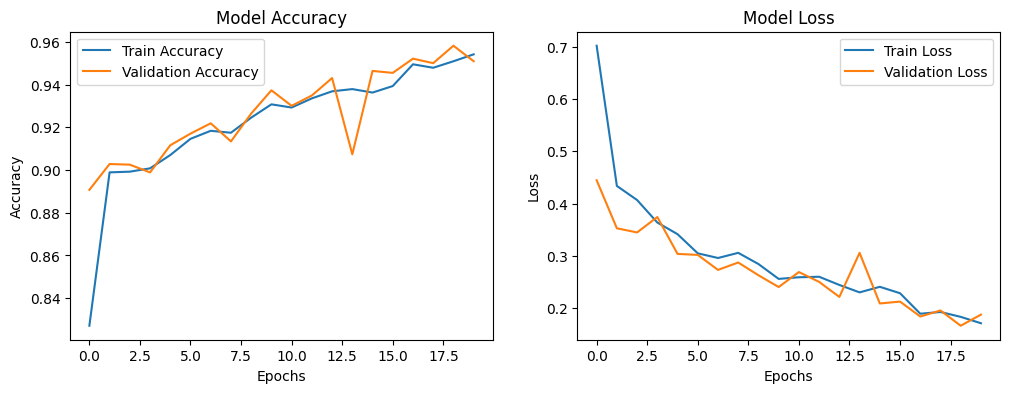

104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9534 - loss: 0.1724
Test Accuracy: 0.9546
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.98      0.98      0.98       816
           2       0.00      0.00      0.00         6
           3       0.96      0.99      0.98      2215
           4       0.00      0.00      0.00         3
           5       0.79      0.81      0.80        93
           6       0.00      0.00      0.00         1
           7       0.76      0.76      0.76       117
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        32

    accuracy                           0.95      3303
   macro avg       0.35      0.35      0.35      3303
weighted avg       0.94      0.95      0.95      3303

Weighted F1 Score: 0.9455


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt



# Get input shape and number of classes
input_shape = X_train.shape[1:]  # (timesteps, features)
num_classes = len(np.unique(y_train))

# Function to plot training history
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.show()

# Train and evaluate the model
def train_model(model, X_train, y_train, X_val, y_val):
    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stopping]
    )

    # Plot training history
    plot_history(history)

    return model

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    # Test evaluation
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predictions
    y_pred = model.predict(X_test).argmax(axis=1)

    # Classification report
    print(classification_report(y_test, y_pred))

    # F1 Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1:.4f}")

# RNN Model (LSTM-based)
def build_rnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        layers.LSTM(64),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN Model
def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=5, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate the RNN model
print("\nTraining RNN Model...")
rnn_model = build_rnn_model(input_shape, num_classes)
rnn_model = train_model(rnn_model, X_train, y_train, X_val, y_val)
evaluate_model(rnn_model, X_test, y_test)



In [ ]:
def build_simple_rnn_model(input_shape, num_classes):
  # Define the SimpleRNN model
  model = models.Sequential([
    layers.SimpleRNN(64, return_sequences=True, input_shape=input_shape),
    layers.SimpleRNN(64),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
  ])
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model


Training Simple RNN Model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9539 - loss: 0.1651 - val_accuracy: 0.6945 - val_loss: 1.5079
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8053 - loss: 0.7439 - val_accuracy: 0.8995 - val_loss: 0.3787
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9043 - loss: 0.4168 - val_accuracy: 0.9043 - val_loss: 0.4225
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9039 - loss: 0.4255 - val_accuracy: 0.9031 - val_loss: 0.3504
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.8989 - loss: 0.4279 - val_accuracy: 0.9025 - val_loss: 0.3516
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9074 - loss: 0.3659 - val_accuracy: 0.9119 - val_loss: 0.3302
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9036 - loss: 0.3698 - val_accuracy: 0.8168 - val_loss: 0.7593
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.8637 - loss: 0.5504 - 

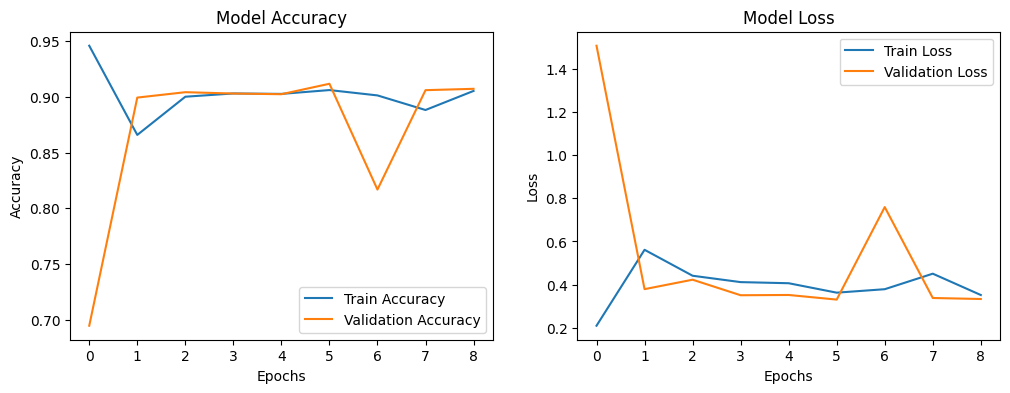

104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9025 - loss: 0.3470
Test Accuracy: 0.9061
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.91      0.95      0.93       816
           2       0.00      0.00      0.00         6
           3       0.91      0.99      0.95      2215
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00         1
           7       0.78      0.15      0.26       117
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        32

    accuracy                           0.91      3303
   macro avg       0.26      0.21      0.21      3303
weighted avg       0.86      0.91      0.87      3303

Weighted F1 Score: 0.8742


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Train and evaluate the RNN model
print("\nTraining Simple RNN Model...")
simple_rnn_model = build_simple_rnn_model(input_shape, num_classes)
simple_rnn_model = train_model(rnn_model, X_train, y_train, X_val, y_val)
evaluate_model(simple_rnn_model, X_test, y_test)


Training CNN Model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8888 - loss: 0.4261 - val_accuracy: 0.9734 - val_loss: 0.0914
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9692 - loss: 0.1111 - val_accuracy: 0.9797 - val_loss: 0.0770
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9758 - loss: 0.0885 - val_accuracy: 0.9840 - val_loss: 0.0664
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9804 - loss: 0.0648 - val_accuracy: 0.9864 - val_loss: 0.0594
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9853 - loss: 0.0556 - val_accuracy: 0.9873 - val_loss: 0.0559
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9871 - loss: 0.0444 - val_accuracy: 0.9870 - val_loss: 0.0731
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9860 - loss: 0.0423 - val_accuracy: 0.9888 - val_loss: 0.0691
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9882 - loss: 0.0343 - val_accuracy: 0

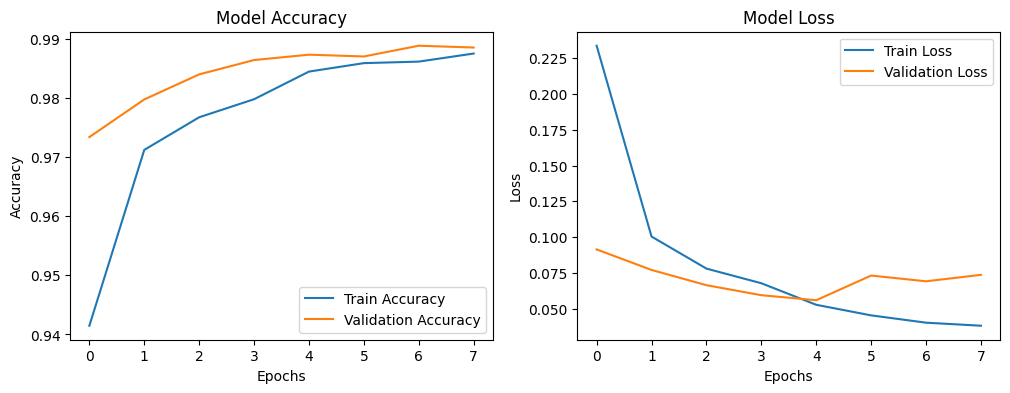

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9891 - loss: 0.0432
Test Accuracy: 0.9888
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       1.00      0.99      0.99       816
           2       1.00      0.67      0.80         6
           3       0.99      1.00      1.00      2215
           4       0.00      0.00      0.00         3
           5       1.00      0.98      0.99        93
           6       0.00      0.00      0.00         1
           7       0.93      0.96      0.94       117
           8       0.00      0.00      0.00         5
           9       0.74      0.81      0.78        32

    accuracy                           0.99      3303
   macro avg       0.65      0.63      0.63      3303
weighted avg       0.99      0.99      0.99      3303

Weighted F1 Score: 0.9875


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Train and evaluate the CNN model
print("\nTraining CNN Model...")
cnn_model = build_cnn_model(input_shape, num_classes)
cnn_model = train_model(cnn_model, X_train, y_train, X_val, y_val)
evaluate_model(cnn_model, X_test, y_test)


In [ ]:
# Import necessary modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
# Import EarlyStopping directly from tensorflow.keras.callbacks
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head Self-Attention
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed Forward Network
    ff = layers.Dense(ff_dim, activation="relu")(x)
    ff = layers.Dense(inputs.shape[-1])(ff)
    x = layers.Dropout(dropout)(ff)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff)
    return x

# Build the Transformer Model
def build_transformer_model(input_shape, num_classes, num_heads=4, head_size=64, ff_dim=128, num_transformer_blocks=2, dropout=0.1):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    embedding_layer = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])
    embeddings = embedding_layer(positions)
    x = inputs + embeddings

    # Transformer Encoder Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Pooling and Classification
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

In [ ]:
# Train and evaluate the model
def train_and_evaluate_transformer(X_train, y_train, X_val, y_val, X_test, y_test):
    # Build the model
    model = build_transformer_model(input_shape, num_classes)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stopping]
    )

    # Plot training history
    plot_history(history)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predictions and classification report
    y_pred = model.predict(X_test).argmax(axis=1)
    print(classification_report(y_test, y_pred))

    # Weighted F1 Score
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"Weighted F1 Score: {f1:.4f}")

    return model

Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 56s 165ms/step - accuracy: 0.2809 - loss: 2.1846 - val_accuracy: 0.2555 - val_loss: 1.7969
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 61s 118ms/step - accuracy: 0.3943 - loss: 1.6732 - val_accuracy: 0.6685 - val_loss: 1.3312
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.6756 - loss: 1.2719 - val_accuracy: 0.6685 - val_loss: 1.0808
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.6807 - loss: 1.0753 - val_accuracy: 0.6685 - val_loss: 0.9917
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.6715 - loss: 1.0361 - val_accuracy: 0.6685 - val_loss: 0.9594
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.6694 - loss: 1.0200 - val_accuracy: 0.6685 - val_loss: 0.9441
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.6645 - loss: 0.9962 - val_accuracy: 0.6685 - val_loss: 0.9355
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.6752 - loss: 0

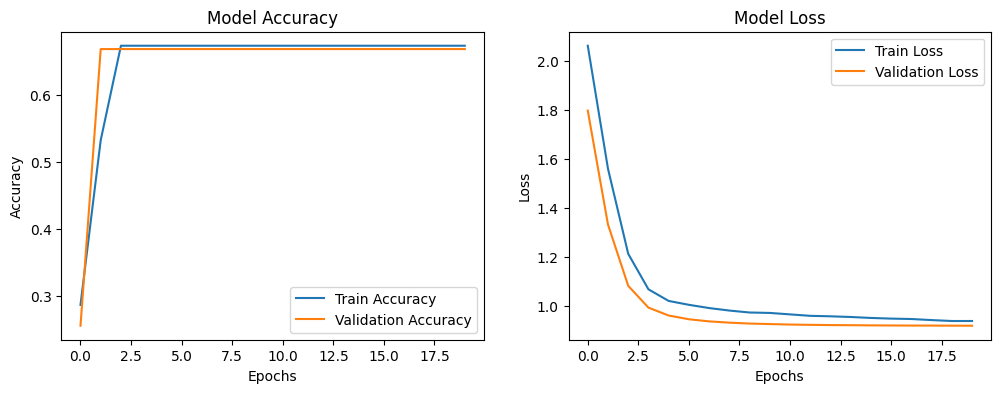

104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6851 - loss: 0.9337
Test Accuracy: 0.6706
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00       816
           2       0.00      0.00      0.00         6
           3       0.67      1.00      0.80      2215
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        93
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00       117
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        32

    accuracy                           0.67      3303
   macro avg       0.07      0.10      0.08      3303
weighted avg       0.45      0.67      0.54      3303

Weighted F1 Score: 0.5384


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Train and evaluate the transformer model
transformer_model = train_and_evaluate_transformer(X_train, y_train, X_val, y_val, X_test, y_test)